In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.f2py.symbolic import as_complex
from tqdm.contrib import itertools
from scipy.ndimage import median_filter

from hsdfmpm.mpm import InstrumentResponseFunction
from hsdfmpm.mpm.flim.utils import get_phasor_coordinates, polar_from_cartesian, cartesian_from_polar, \
    plot_universal_circle, fit_phasor, cartesian_from_lifetime, find_intersection_with_circle, project_to_line, \
    lifetime_from_cartesian, get_endpoints_from_projection, phasor_svd, convert_vT_to_point_slope

rng = np.random.default_rng(42)
omega = 2 * np.pi * 80e6

def generate_decay_histogram(tau1, tau2=None, alpha=1.0, n_photons=1e3, bin_count=256, t_max=10.0e-9):
    tau1  = np.asanyarray(tau1,  dtype=float)
    if tau2 is None:
        tau2  = tau1
        alpha = 1.0
    tau2  = np.asanyarray(tau2,  dtype=float)
    alpha = np.asanyarray(alpha, dtype=float)

    t_edges = (np.linspace(0, t_max, bin_count + 1))[np.newaxis, np.newaxis, ...]
    t0, t1 = t_edges[..., :-1], t_edges[..., 1:]

    p1 = np.exp(-t0 / tau1) - np.exp(-t1 / tau1)
    p2 = np.exp(-t0 / tau2) - np.exp(-t1 / tau2)
    probs = alpha * p1 + (1 - alpha) * p2

    probs /= np.sum(probs, axis=-1, keepdims=True)
    flat = probs.reshape(-1, bin_count)
    hists = np.asarray([rng.multinomial(n_photons, p).astype(np.uint32) for p in flat]).reshape(probs.shape)
    return hists

def convolve_with_irf(decay, irf):
    while decay.ndim < irf.ndim:
        decay = np.expand_dims(decay, axis=0)
    T = decay.shape[-1]
    decay_area = np.sum(decay, axis=-1, keepdims=True)
    conv_L = decay.shape[-1] + irf.shape[-1] -  1
    decay = np.fft.fft(decay, n=conv_L, axis=-1)
    irf = np.fft.fft(irf / irf.sum(axis=-1, keepdims=-1), n=conv_L, axis=-1)
    decay *= irf
    decay = np.fft.ifft(decay, axis=-1).real
    return decay[..., :T]

# IRF

C:\Users\jdivers\PycharmProjects\hsdfmpm\src\hsdfmpm\mpm\flim\flim.py:234: Warning: Loading default IRF file, 'C:\Users\jdivers\.hsdfmpm\irf\irf.pkl'.
  irf = get_irf(path)


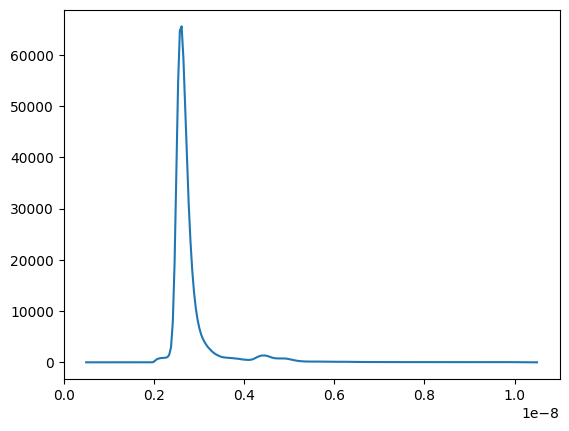

In [6]:
t = np.linspace(0.5, 10.5, 256) / 1e9
irf = InstrumentResponseFunction.load()
plt.plot(t, np.sum(irf.decay, axis=(0, 1, 2)))
plt.show()

## Visualize IRF correction

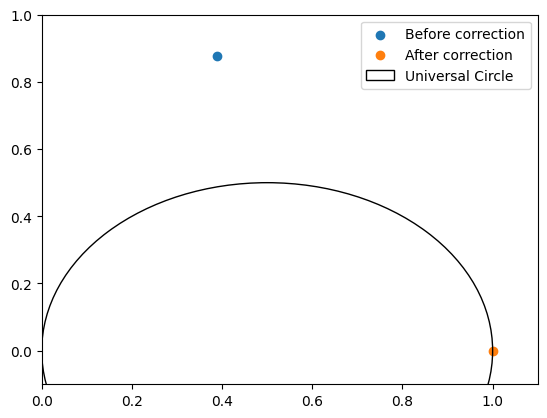

In [8]:
P, photons = get_phasor_coordinates(irf.decay, as_complex=True)
g, s = P.real, P.imag
plt.scatter(g.flatten(), s.flatten(), label="Before correction")
P *= irf.correction
g, s = P.real, P.imag
plt.scatter(g.flatten(), s.flatten(), label="After correction")
plot_universal_circle(omega)
plt.xlim((0, 1.1))
plt.ylim((-0.1, 1))
plt.legend()
plt.show()

# Simualte some data

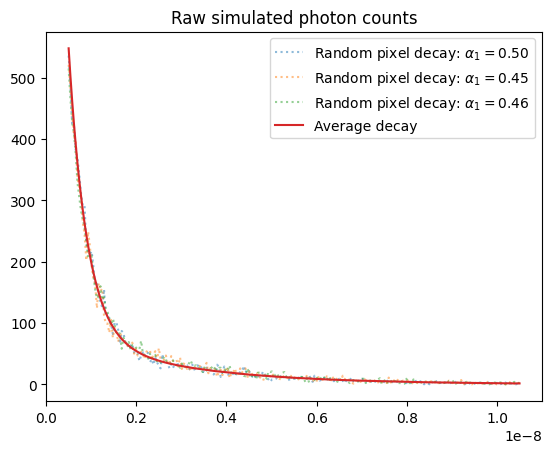

In [9]:
tau1_value = 0.4e-9
tau2_value = 2.5e-9
alpha_range = [0.45, 0.55]
tau1 = np.ones((256, 256, 1)) * tau1_value
tau2 = np.ones((256, 256, 1)) * tau2_value
alpha = rng.uniform(*alpha_range, size=(256, 256, 1))
decay = generate_decay_histogram(tau1=tau1, tau2=tau2, alpha=alpha, n_photons=10000)
decay = decay[np.newaxis, ...]
for _ in range(3):
    i, j = rng.integers(0, 256, size=2)
    plt.plot(t, decay[:, i, j].squeeze(), alpha=0.5, linestyle=':', label=r'Random pixel decay: $\alpha_1 = $' + f'{alpha[i, j].item():.2f}')
plt.plot(t, np.mean(decay, axis=(0, 1, 2)), label='Average decay')
plt.title('Raw simulated photon counts')
plt.legend()
plt.show()

## Pre-convolution decay

### Get phasor

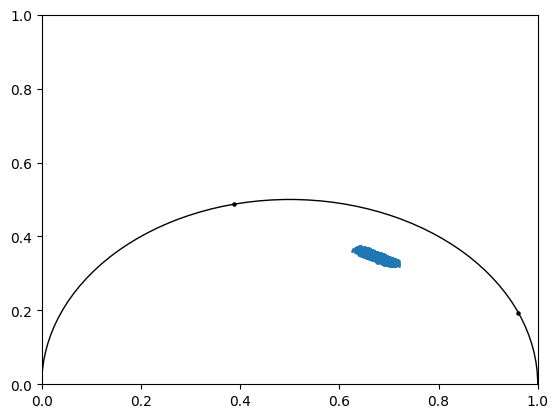

In [10]:
g, s, photons = get_phasor_coordinates(decay)
plt.scatter(g.flatten(), s.flatten(), s=1)
plot_universal_circle(omega, tau_labels=[tau1_value, tau2_value])
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

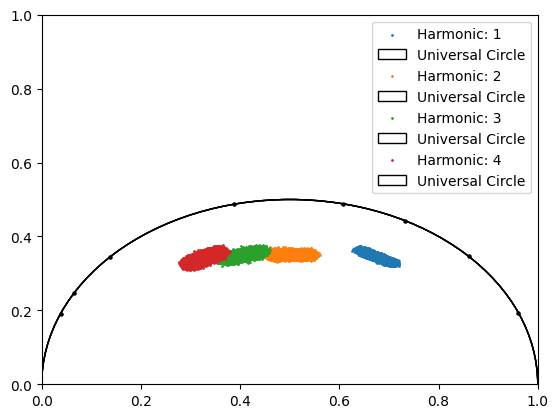

In [11]:
for n in range(1, 5):
    g, s, photons = get_phasor_coordinates(decay, harmonic=n)
    plt.scatter(g.flatten(), s.flatten(), s=1, label=f'Harmonic: {n}')
    plot_universal_circle(omega, tau_labels=[tau1_value, tau2_value], harmonic=n)
plt.legend()
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

## Compare with ground truth in phasor space

Average distance: 0.02


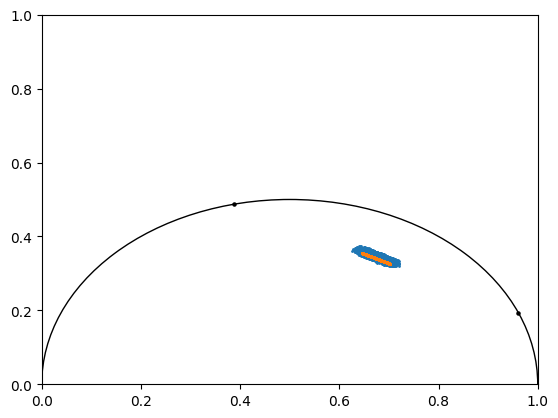

In [12]:
g, s, _ = get_phasor_coordinates(decay)
g1, s1 = cartesian_from_lifetime(tau1, omega)
g2, s2 = cartesian_from_lifetime(tau2, omega)
x, y = alpha * g1 + (1-alpha) * g2, alpha * s1 + (1-alpha) * s2
distance = np.mean(np.hypot(g - x, s - y))
print(f'Average distance: {distance:.2f}')
plt.scatter(g.flatten(), s.flatten(), s=1)
plot_universal_circle(omega, tau_labels=[tau1_value, tau2_value])
plt.scatter(x.flatten(), y.flatten(), s=1)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

## Compare with ground truth in Tau/alpha

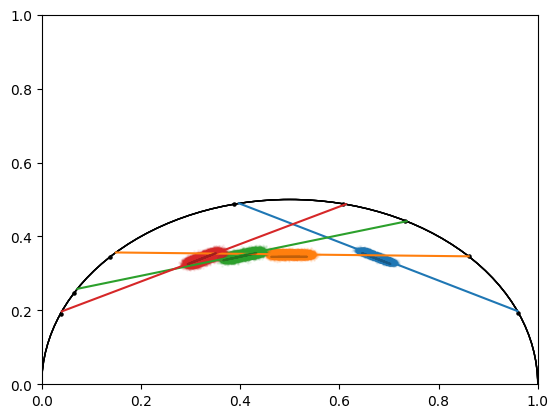

In [13]:
for n in range(1, 5):
    g, s, _ = get_phasor_coordinates(decay, harmonic=n)
    b, m = fit_phasor(g, s, ratio_threshold=0)
    x, y = find_intersection_with_circle(b, m)
    plt.scatter(g.flatten(), s.flatten(), s=1, alpha=0.05)
    plot_universal_circle(omega, harmonic=n, tau_labels=[tau1_value, tau2_value])
    plt.plot(x, y)
    g1, s1 = cartesian_from_lifetime(tau1, omega, harmonic=n)
    g2, s2 = cartesian_from_lifetime(tau2, omega, harmonic=n)
    x, y = alpha * g1 + (1-alpha) * g2, alpha * s1 + (1-alpha) * s2
    plt.plot(x.flatten(), y.flatten(), 'black', alpha=0.25)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

## Convolved

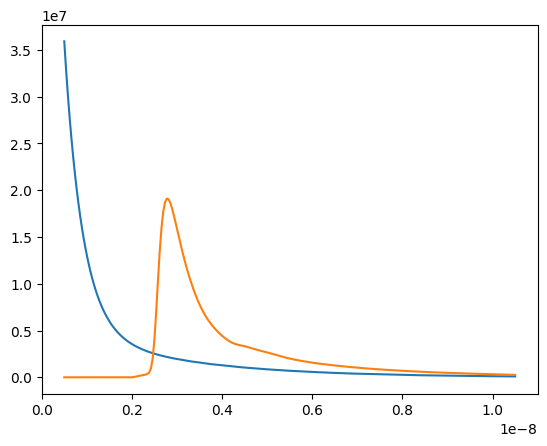

In [14]:
plt.plot(t, np.sum(decay, axis=(0, 1, 2)))
decay = convolve_with_irf(decay, irf.decay)
plt.plot(t, np.sum(decay, axis=(0, 1, 2)))
plt.show()

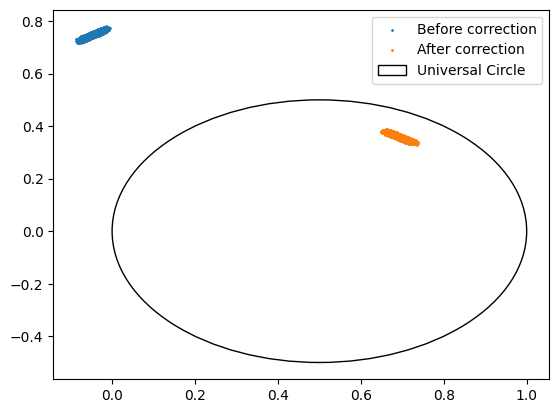

In [16]:
P, photons = get_phasor_coordinates(decay, as_complex=True)
g3, s3 = P.real, P.imag
plt.scatter(g3.flatten(), s3.flatten(), s=1, label="Before correction")
P *= irf.correction
g3, s3 = P.real, P.imag
plt.scatter(g3.flatten(), s3.flatten(), s=1, label="After correction")
plot_universal_circle(omega)
plt.legend()
plt.show()

In [17]:
loss = np.mean(np.sqrt((g3 - g) ** 2 + (s3 - s) ** 2))
print(f'Average distance from pre-convolution in phasor space: {loss:.4f}')
g1, s1 = cartesian_from_lifetime(tau1, omega)
g2, s2 = cartesian_from_lifetime(tau2, omega)
x, y = alpha * g1 + (1-alpha) * g2, alpha * s1 + (1-alpha) * s2
loss = np.mean(np.hypot(g3 - x, s3 - y))
print(f'Average distance from ground-truth in phasor space: {loss:.4f}')

Average distance from pre-convolution in phasor space: 0.3680
Average distance from ground-truth in phasor space: 0.0363


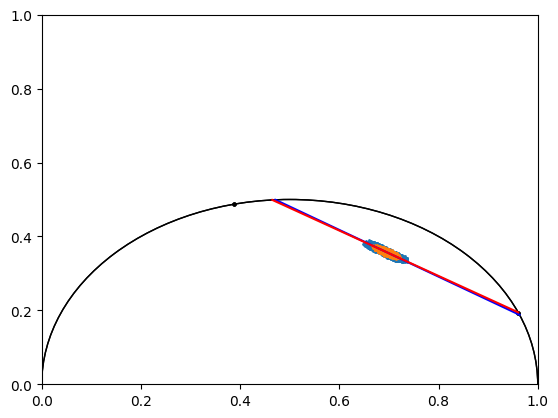

In [18]:
g, s = g3, s3
b, m = fit_phasor(g, s, ratio_threshold=0)
x, y = find_intersection_with_circle(b, m)
gp, sp = project_to_line(g, s, x, y)
tau = lifetime_from_cartesian(x, y, omega)
alphas, tau_m = get_endpoints_from_projection(gp, sp, x, y, tau)
plt.scatter(g.flatten(), s.flatten(), s=1)
plot_universal_circle(omega, tau_labels=[tau1_value, tau2_value])
plt.plot(x, y, 'blue')

g, s = median_filter(g.squeeze(), (3, 3))[np.newaxis, ...], median_filter(s.squeeze(), (3, 3))[np.newaxis, ...]
b, m = fit_phasor(g, s, ratio_threshold=0)
x, y = find_intersection_with_circle(b, m)
gp, sp = project_to_line(g, s, x, y)
tau = lifetime_from_cartesian(x, y, omega)
alphas, tau_m = get_endpoints_from_projection(gp, sp, x, y, tau)
plt.scatter(g.flatten(), s.flatten(), s=1)
plot_universal_circle(omega, tau_labels=[tau1_value, tau2_value])
plt.plot(x, y, 'red')

plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()